In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import date

from sklearn.metrics import roc_auc_score
import catboost as cb
from catboost import Pool
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_excel(os.getcwd()+'/testA.xlsx')

In [3]:
df = df[['Employee_Name', 'Salary', 'Position', 'State', 'Zip', 'Date of birth',
       'Sex', 'Marital status', 'Citizen status', 'Date of Hire',
       'Term Reason', 'Employment Status', 'Department', 'RecruitmentSource',
       'Performance score', 'Engagement Survey', 'Employee satisfaction',
       'Special Projects Count', 'Days late, last 30', 'Absences']]

In [4]:
df = df.iloc[:311]

In [5]:
data = df.copy()

In [6]:
df.drop('Employee_Name', axis = 1, inplace = True)
df.head()

,Salary,Position,State,Zip,Date of birth,Sex,Marital status,Citizen status,Date of Hire,Term Reason,Employment Status,Department,RecruitmentSource,Performance score,Engagement Survey,Employee satisfaction,Special Projects Count,"Days late, last 30",Absences
0,62506.0,Production Technician I,MA,1960,1983-10-07 00:00:00,M,Single,US Citizen,2011-05-07 00:00:00,N/A-StillEmployed,Active,Production,LinkedIn,Exceeds,4.60,5.0,0.0,0.0,1.0
1,104437.0,Sr. DBA,MA,2148,1975-05-05 00:00:00,M,Married,US Citizen,3/30/2015,career change,Voluntarily Terminated,IT/IS,Indeed,Fully Meets,4.96,3.0,6.0,0.0,17.0
2,64955.0,Production Technician II,MA,1810,09/19/88,F,Married,US Citizen,2011-05-07 00:00:00,hours,Voluntarily Terminated,Production,LinkedIn,Fully Meets,3.02,3.0,0.0,0.0,3.0
3,64991.0,Production Technician I,MA,1886,09/27/88,F,Married,US Citizen,2008-07-01 00:00:00,N/A-StillEmployed,Active,Production,Indeed,Fully Meets,4.84,5.0,0.0,0.0,15.0
4,50825.0,Production Technician I,MA,2169,1989-08-09 00:00:00,F,Divorced,US Citizen,2011-11-07 00:00:00,return to school,Voluntarily Terminated,Production,Google Search,Fully Meets,5.00,4.0,0.0,0.0,2.0


In [7]:
df.describe()

,Salary,Engagement Survey,Employee satisfaction,Special Projects Count,"Days late, last 30",Absences
count,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000
mean,69020.684887,4.110000,3.890675,1.218650,0.414791,10.237942
std,25156.636930,0.789938,0.909241,2.349421,1.294519,5.852596
min,45046.000000,1.120000,1.000000,0.000000,0.000000,1.000000
25%,55501.500000,3.690000,3.000000,0.000000,0.000000,5.000000
50%,62810.000000,4.280000,4.000000,0.000000,0.000000,10.000000
75%,72036.000000,4.700000,5.000000,0.000000,0.000000,15.000000
max,250000.000000,5.000000,5.000000,8.000000,6.000000,20.000000


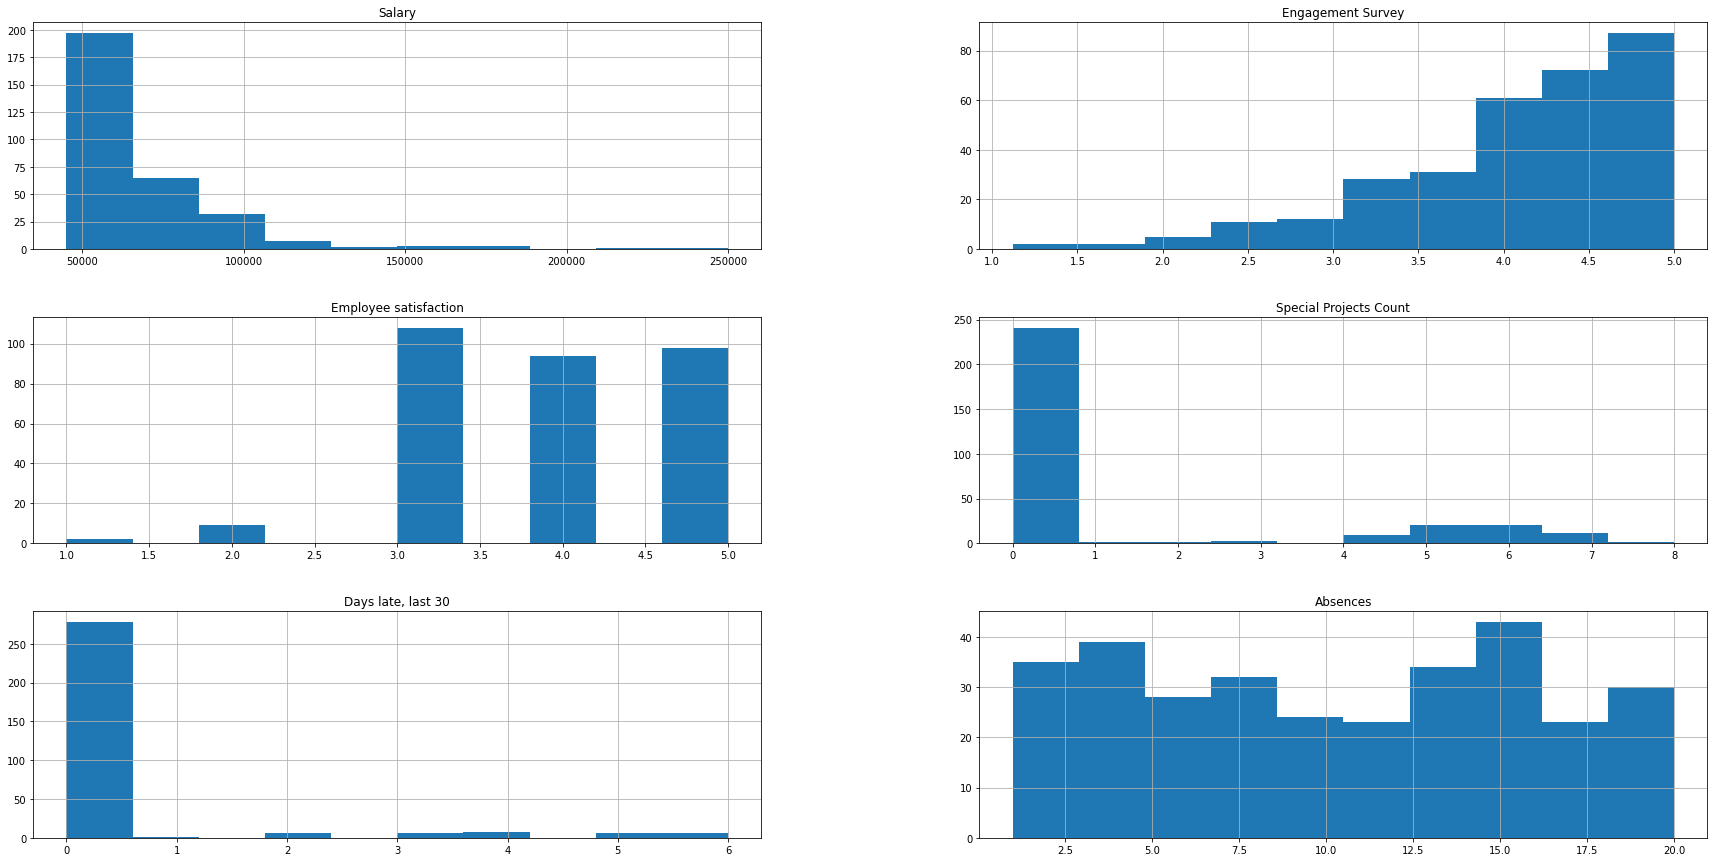

In [8]:
df[df.describe().columns].hist(figsize = (30,15))
plt.show()

In [9]:
df.isna().sum()

Salary                     0
Position                   0
State                      0
Zip                        0
Date of birth              0
Sex                        0
Marital status             0
Citizen status             0
Date of Hire               0
Term Reason               13
Employment Status         13
Department                 0
RecruitmentSource          0
Performance score          0
Engagement Survey          0
Employee satisfaction      0
Special Projects Count     0
Days late, last 30         0
Absences                   0
dtype: int64

### Creating age from date of birth

In [17]:
df['Date of birth']  = pd.to_datetime(df['Date of birth'])

In [18]:
today = date.today()
today

datetime.date(2021, 8, 31)

In [19]:
df['age'] = today.year - df['Date of birth'].dt.year

### Creating months at work form date of hire

In [20]:
df['Date of Hire'] = pd.to_datetime(df['Date of Hire'])

In [21]:
df['months_at_work'] = today.year*12+today.month - (df['Date of Hire'].dt.month+df['Date of Hire'].dt.year*12)

### Create 'month_of_hire'

In [22]:
df['month of hire'] = df['Date of Hire'].dt.month

### Transforming performance score to numerical

In [23]:
performance = {'Exceeds':4, 'Fully Meets': 3, 'Needs Improvement':2, 'PIP':1}

In [24]:
df['performance_numerical'] = df['Performance score'].apply(lambda x:performance[x])  

### EDA

In [26]:
df.dtypes

Salary                           float64
Position                          object
State                             object
Zip                               object
Date of birth             datetime64[ns]
Sex                               object
Marital status                    object
Citizen status                    object
Date of Hire              datetime64[ns]
Term Reason                       object
Employment Status                 object
Department                        object
RecruitmentSource                 object
Performance score                 object
Engagement Survey                float64
Employee satisfaction            float64
Special Projects Count           float64
Days late, last 30               float64
Absences                         float64
age                                int64
months_at_work                     int64
month of hire                      int64
performance_numerical              int64
dtype: object

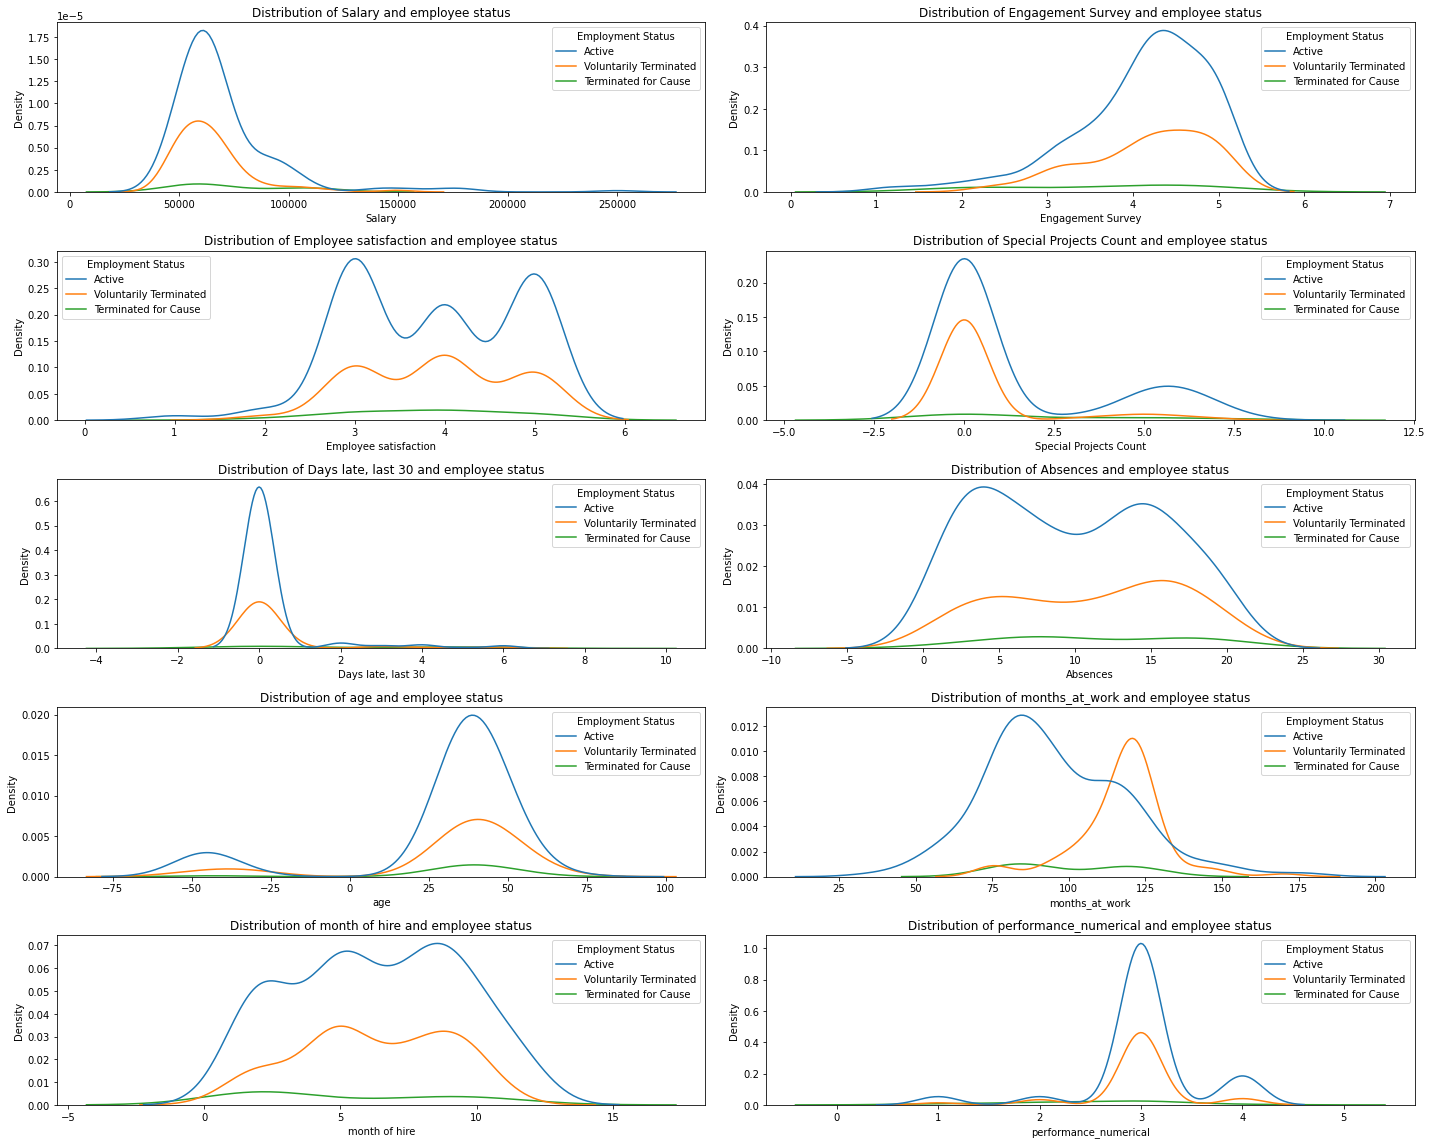

In [37]:
int_cols = df.select_dtypes(include = ['float64', 'int64'])


fig, axes = plt.subplots(figsize = (20,16), ncols = 2, nrows = 5)
cols = int_cols.columns


for i in range(5):
    for j in range(i, i+2):
        sns.kdeplot(ax = axes[i, j-i], data = df, x = cols[i+j], hue = 'Employment Status')
        axes[i, j-i].set_title(f'Distribution of {cols[i+j]} and employee status')
        
fig.tight_layout()
plt.show()

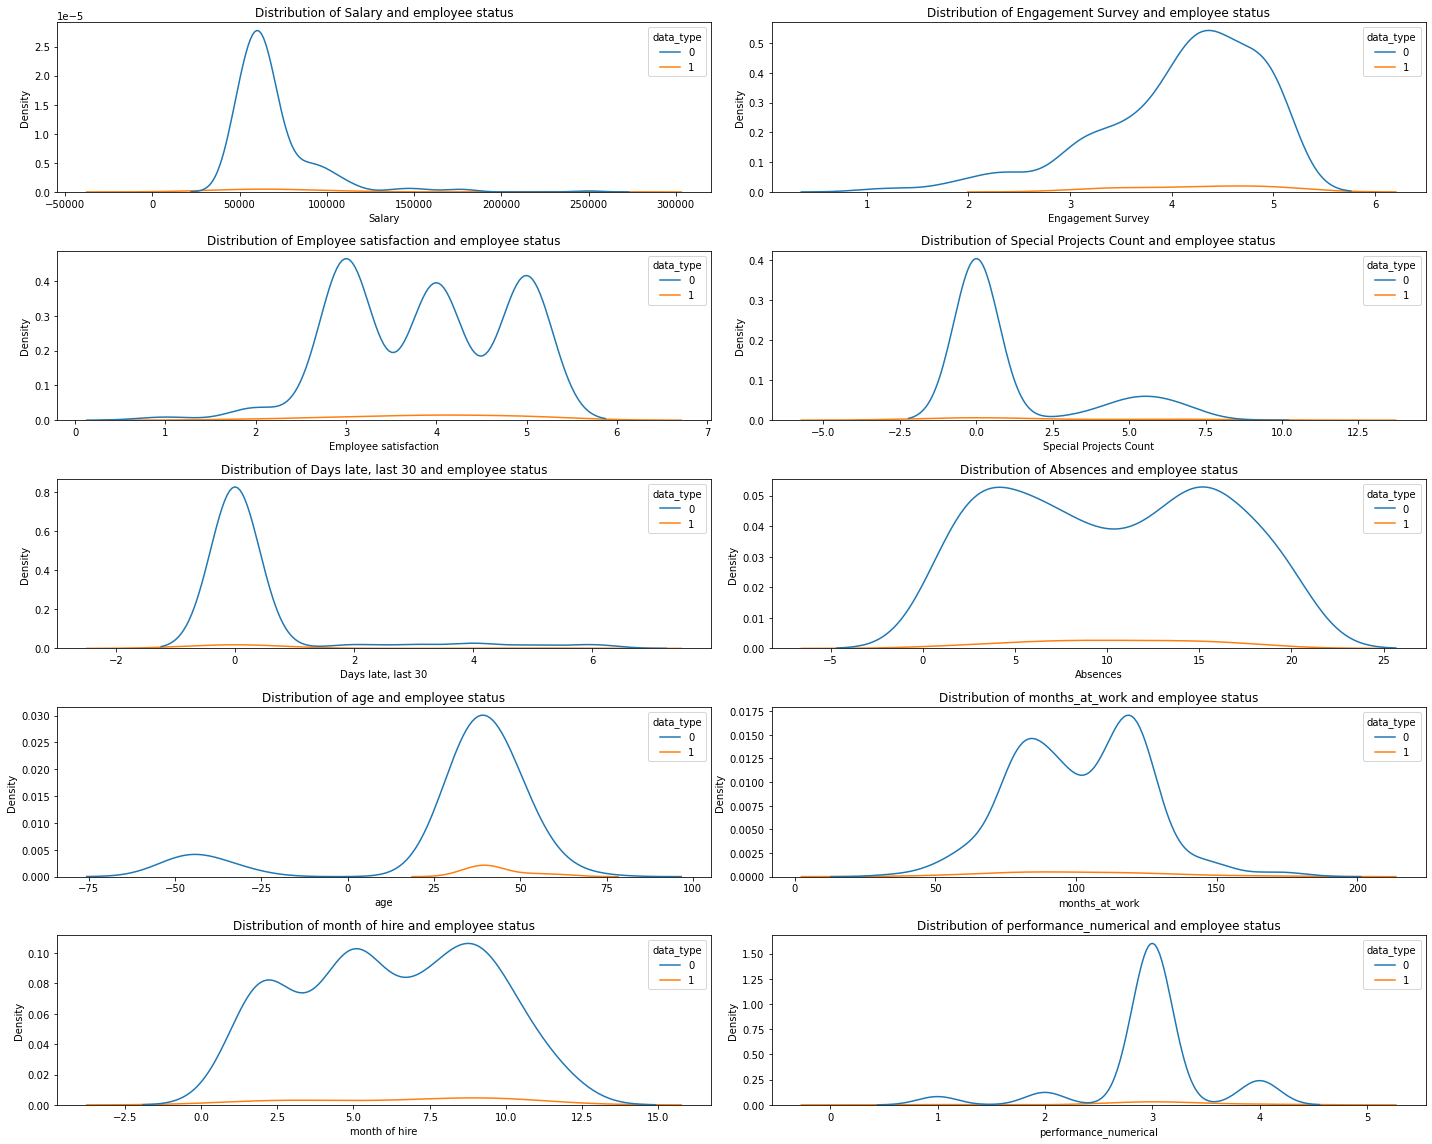

In [47]:
df['data_type'] = df['Employment Status'].isna().astype(int)

fig, axes = plt.subplots(figsize = (20,16), ncols = 2, nrows = 5)
cols = int_cols.columns


for i in range(5):
    for j in range(i, i+2):
        sns.kdeplot(ax = axes[i, j-i], data = df, x = cols[i+j], hue = 'data_type')
        axes[i, j-i].set_title(f'Distribution of {cols[i+j]} and employee status')
        
fig.tight_layout()
plt.show()

In [50]:
df.shape

(311, 23)

### Transform 'state'

In [ ]:
df.select_dtypes(include=['object']).nunique()

In [ ]:
df.State.value_counts()[:10]

In [ ]:
df['State']=np.where(df['State'] !='MA', 'notMA', df['State'])

### 'Salary' revisited

In [ ]:
df['Salary_difference'] = df.apply(lambda x:x.Salary - df[df.Position == x.Position].Salary.median(), axis= 1)

In [ ]:
df.Salary.corr(df['Salary_difference'])

### Recruitment Source

In [ ]:
df.RecruitmentSource.value_counts()

In [ ]:
df = df[(df.RecruitmentSource!='On-line Web application')&(df.RecruitmentSource!='Other')]

In [ ]:
fig, axes = plt.subplots(figsize = (16, 6), ncols = 2, nrows = 1)
sns.barplot(ax = axes[0], data = df, x = 'Employment Status', y = 'Salary')
axes[0].set_ylim(60000, 90000)
sns.barplot(ax = axes[1], data = df, x = 'Employment Status', y = 'Salary_difference')
plt.show()

In [ ]:
fig, axes = plt.subplots(figsize = (16,16), ncols = 2, nrows = 4)
cols = df.describe().columns

for i in range(4):
    for j in range(i, i+2):
        sns.barplot(ax = axes[i, j-i], data = df, x = 'Employment Status', y = cols[i+j])
        axes[i, j-i].set_title(f'Average {cols[i+j]} vs employee status')
        
fig.tight_layout()
plt.show()

In [ ]:
pd.crosstab(df.Sex,df['Employment Status'])

In [ ]:
from scipy import stats
stats.chi2_contingency(pd.crosstab(df.Sex,df['Employment Status']))

In [ ]:
fig, axes = plt.subplots(figsize = (16, 18), nrows = 3, ncols = 2)

table=pd.crosstab(df.Sex,df['Employment Status'])
table.div(table.sum(1).astype(float), axis=0).plot(ax = axes[0,0], kind='bar', stacked=True)

table=pd.crosstab(df['Marital status'],df['Employment Status'])
table.div(table.sum(1).astype(float), axis=0).plot(ax = axes[0,1], kind='bar', stacked=True)

table=pd.crosstab(df['Citizen status'], df['Employment Status'])
table.div(table.sum(1).astype(float), axis=0).plot(ax = axes[1,0], kind='bar', stacked=True)

table=pd.crosstab(df['Department'],df['Employment Status'])
table.div(table.sum(1).astype(float), axis=0).plot(ax = axes[1,1], kind='bar', stacked=True)


table=pd.crosstab(df['month of hire'],df['Employment Status'])
table.div(table.sum(1).astype(float), axis=0).plot(ax = axes[2,0], kind='bar', stacked=True)
plt.tight_layout()
plt.show()

In [ ]:
def zodiac_sign(date):
    month, day = date.month, date.day
    if month == 12:
        astro_sign = 'sagittarius' if (day < 22) else 'capricorn'
    elif month == 1:
        astro_sign = 'capricorn' if (day < 20) else 'aquarius'
    elif month == 2:
        astro_sign = 'aquarius' if (day < 19) else 'pisces'
    elif month == 3:
        astro_sign = 'pisces' if (day < 21) else 'aries'
    elif month == 4:
        astro_sign = 'aries' if (day < 20) else 'taurus'
    elif month == 5:
        astro_sign = 'taurus' if (day < 21) else 'gemini'
    elif month == 6:
        astro_sign = 'gemini' if (day < 21) else 'cancer'
    elif month == 7:
        astro_sign = 'cancer' if (day < 23) else 'leo'
    elif month == 8:
        astro_sign = 'leo' if (day < 23) else 'virgo'
    elif month == 9:
        astro_sign = 'virgo' if (day < 23) else 'libra'
    elif month == 10:
        astro_sign = 'libra' if (day < 23) else 'scorpio'
    elif month == 11:
        astro_sign = 'scorpio' if (day < 22) else 'sagittarius'
    return astro_sign

In [ ]:
df['zodiac_sign'] = df['Date of birth'].apply(lambda x:zodiac_sign(x))

In [ ]:
fig, ax = plt.subplots(figsize = (12,6),nrows= 1,ncols = 1)
table=pd.crosstab(df['zodiac_sign'],df['Employment Status'])
table.div(table.sum(1).astype(float), axis=0).plot(ax = ax,kind='bar', stacked=True)
plt.tight_layout()
plt.show()

In [ ]:
stats.chi2_contingency(pd.crosstab(df['zodiac_sign'],df['Employment Status']))

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
df.drop(columns = ['Position', 'Zip', 'Date of birth', 'Date of Hire', 'Term Reason', 'Performance score'], axis = 1, inplace = True)

In [ ]:
df.columns

In [ ]:
df['Employment Status'].value_counts()/len(df)*100

In [ ]:
df_three_cat = df.copy()

In [ ]:
df['Employment Status']=np.where(df['Employment Status'] =='Voluntarily Terminated', 'Inactive', df['Employment Status'])
df['Employment Status']=np.where(df['Employment Status'] =='Terminated for Cause', 'Inactive', df['Employment Status'])

In [ ]:
df.head()

In [ ]:
plt.figure(figsize = (16,6))

mask = np.triu(np.ones_like(train.corr(), dtype=bool), +1)
heatmap = sns.heatmap(train.corr(), vmin = -1, vmax = 1, mask = mask, annot = True, cmap = 'BrBG')

heatmap.set_title('Correlation between features', fontsize = 18, pad = 12)
plt.show()

In [ ]:
sns.kdeplot(data = df, x = 'months_at_work', hue='Employment Status', fill=True)

In [ ]:
sns.kdeplot(data = df, x = 'Absences', hue='Employment Status', fill=True)

In [ ]:
df_cat = df.copy()

In [ ]:
df_cat.columns

In [ ]:
cat_cols = df.select_dtypes(include = ['object']).columns
for col in cat_cols:
    df[col] = df[col].astype('category').cat.codes+1

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(df_cat.iloc[:-13,:].drop(columns = 'Employment Status', axis = 1),\
                                                df_cat.iloc[:-13,5],
                                                random_state=10, test_size=0.20)

In [ ]:
test = df_cat.iloc[:-14:-1,:].drop(columns = 'Employment Status', axis = 1)
test = test.sort_index()

In [ ]:
cat_cols = train_X.select_dtypes(include = ['object']).columns
cat_cols_idx = []

for col in cat_cols:
    cat_cols_idx.append(train_X.columns.get_loc(col))

In [ ]:
print(train_X.shape, train_y.shape)

In [ ]:
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}

cbm = cb.CatBoostClassifier()
cb_model = GridSearchCV(cbm, params, scoring="roc_auc", cv = 3)
cb_model.fit(train_X, train_y, cat_features = cat_cols_idx)

In [ ]:
cb_model.best_params_

In [ ]:
clf = cb.CatBoostClassifier(eval_metric="AUC", \
                            depth=10, iterations= 300, l2_leaf_reg= 9, learning_rate= 0.15)
clf.fit(train_X,train_y, cat_features= cat_cols_idx)

In [ ]:
plot_confusion_matrix(clf, train_X, train_y)
plt.show()

In [ ]:
print(classification_report(train_y,clf.predict(train_X)))

In [ ]:
roc_auc_score(train_y,clf.predict_proba(train_X)[:,1])

In [ ]:
plot_confusion_matrix(clf, test_X, test_y)

In [ ]:
print(classification_report(test_y,clf.predict(test_X)))

In [ ]:
roc_auc_score(test_y,clf.predict_proba(test_X)[:,1])

In [ ]:
a = pd.DataFrame(clf.predict_proba(test), columns = ['Active', 'Inactive']) 

In [ ]:
a['name'] = data.iloc[:-14:-1, 0].sort_index().values

In [ ]:
a = a[['name', 'Active', 'Inactive']]
a

In [ ]:
# train_data = Pool(data=train_X, label=train_y)

# clf.get_feature_importance(train_data)



### Using three categories in the output

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(df_three_cat.iloc[:-13,:].drop(columns = 'Employment Status', axis = 1),\
                                                df_three_cat.iloc[:-13,5],
                                                random_state=10, test_size=0.20)

In [ ]:
test = df_three_cat.iloc[:-14:-1,:].drop(columns = 'Employment Status', axis = 1)
test = test.sort_index()

In [ ]:
cat_cols = train_X.select_dtypes(include = ['object']).columns
cat_cols_idx = []

for col in cat_cols:
    cat_cols_idx.append(train_X.columns.get_loc(col))

In [ ]:
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}

cbm1 = cb.CatBoostClassifier()
cb_model1 = GridSearchCV(cbm1, params, scoring="roc_auc", cv = 3)
cb_model1.fit(train_X, train_y, cat_features = cat_cols_idx)

In [ ]:
cb_model1.best_params_

In [ ]:
clf1 = cb.CatBoostClassifier(eval_metric="AUC", \
                            depth=4, iterations= 300, l2_leaf_reg= 1, learning_rate= 0.03)
clf1.fit(train_X,train_y, cat_features= cat_cols_idx)

In [ ]:

plt.close()
# fig = plt.figure(figsize = (10,10))
plot_confusion_matrix(clf1, train_X, train_y)
plt.show()

In [ ]:
print(classification_report(train_y,clf1.predict(train_X)))

In [ ]:
plot_confusion_matrix(clf1, test_X, test_y)

In [ ]:
print(classification_report(test_y,clf1.predict(test_X)))

In [ ]:
clf1.predict_proba(test)

In [ ]:
a = pd.DataFrame(clf1.predict_proba(test), columns = ['Active', 'Terminated for Cause', 'Voluntarily Terminated']) 

In [ ]:
pd.concat([a, data[]])

In [ ]:
a['name'] = data.iloc[:-14:-1, 0].sort_index().values

In [ ]:
a = a[['name', 'Active', 'Terminated for Cause', 'Voluntarily Terminated']]

In [ ]:
a

### categories a numerical

In [ ]:
# X_train, y_train = df.iloc[:-13,:].drop(columns = 'Employment Status', axis = 1), df.iloc[:-13,5]

In [ ]:
# X_test = df.iloc[:-14:-1,:]

In [ ]:
# params = {'depth': [4, 7, 10],
#           'learning_rate' : [0.01, 0.03, 0.1, 0.15],
#          'l2_leaf_reg': [1,4,9],
#          'iterations': [300]}

# cbm2 = cb.CatBoostClassifier()
# cb_model2 = GridSearchCV(cbm2, params, scoring="roc_auc", cv = 3)
# cb_model2.fit(X_train, y_train)

In [ ]:
# cb_model2.best_params_

In [ ]:
# clf2 = cb.CatBoostClassifier(eval_metric="AUC", \
#                             depth=7, iterations= 300, l2_leaf_reg= 4, learning_rate= 0.01)
# clf2.fit(X_train,y_train)

In [ ]:
# plot_confusion_matrix(clf2, X_train, y_train)

In [ ]:
# print(classification_report(y_train, clf2.predict(X_train)))